# MNIST VAE implementation in Tensorflow

In [1]:
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm,trange

tf.reset_default_graph()

/Users/sergeassaad/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sergeassaad/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sergeassaad/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
# Hyperparameters
z_dim = 10 #latent variable dimensions

# Encoder layer sizes and activations
hidden_dims_enc = [100,100] #encoder & decoder dimensions
all_dims_enc = [784] + hidden_dims_enc + [2*z_dim]
enc_layers = len(all_dims_enc)
activations_enc = [tf.nn.relu,tf.nn.relu,tf.identity]

# Decoder layer sizes and activations
hidden_dims_dec = [100,100]
all_dims_dec = [z_dim] + hidden_dims_dec + [784]
dec_layers = len(all_dims_dec)
activations_dec = [tf.nn.relu,tf.nn.relu,tf.nn.sigmoid]

In [3]:
X_img = tf.placeholder(tf.float32, [None,28,28])
X = tf.reshape(X_img,[-1,784])/255 #map pixel values between 0-1

# Encoder layers
W_enc = [None]*(enc_layers-1)
b_enc = [None]*(enc_layers-1)
h_enc = [None]*enc_layers
h_enc[0] = X

for i in range(enc_layers-1):
    W_enc[i] = tf.Variable(tf.truncated_normal([all_dims_enc[i], all_dims_enc[i+1]], stddev=0.1))
    b_enc[i] = tf.Variable(tf.zeros([all_dims_enc[i+1]]))
    h_enc[i+1] = activations_enc[i](tf.matmul(h_enc[i], W_enc[i]) + b_enc[i])

In [4]:
# Sampling latent vectors z
gaussian_params = h_enc[-1]
mu = gaussian_params[:, :z_dim]
sigma = tf.exp(gaussian_params[:,z_dim:])
z = mu + sigma * tf.random_normal(tf.shape(mu), 0, 1, dtype=tf.float32)

In [5]:
# Decoder layers
W_dec = [None]*(dec_layers-1)
b_dec = [None]*(dec_layers-1)
h_dec = [None]*dec_layers
h_dec[0] = z

for i in range(dec_layers-1):
    W_dec[i] = tf.Variable(tf.truncated_normal([all_dims_dec[i], all_dims_dec[i+1]], stddev=0.1))
    b_dec[i] = tf.Variable(tf.zeros([all_dims_dec[i+1]]))
    h_dec[i+1] = activations_dec[i](tf.matmul(h_dec[i], W_dec[i]) + b_dec[i])

In [6]:
# Reconstructed image
X_rec = h_dec[-1]

# Log Likelihood p(x|z) ~ Bernoulli (for MNIST)
likelihood_ = tf.reduce_sum(X* tf.log(X_rec+1e-8) + (1 - X) * tf.log(1 - X_rec+1e-8), 1)

# KL divergence between q(z|x) ~ Normal and p(z)~ N(0,I)
KL_ = 0.5 * tf.reduce_sum(tf.square(mu) + tf.square(sigma) - tf.log(1e-8+tf.square(sigma)) - z_dim, 1)

likelihood = tf.reduce_mean(likelihood_)
KL = tf.reduce_mean(KL_)

# Loss & optimizer
loss = KL - likelihood
opt = tf.train.AdamOptimizer()
train_step = opt.minimize(loss)

In [7]:
# Load MNIST data
mnist_train,_ = tf.keras.datasets.mnist.load_data(path='mnist.npz')
x_train,_ = mnist_train

# Training parameters
num_epochs = 30
batch_size = 500
N_train = len(x_train)

In [8]:
# Training
with tf.Session() as sess:
    min_loss = float('inf')
    sess.run(tf.global_variables_initializer())
    for epoch in range(num_epochs):
        print("Epoch {}!".format(epoch))
        print(min_loss)
        for i in trange(N_train//batch_size):
            x_batch = x_train[i:i+batch_size]
            loss_batch,_ = sess.run([loss,train_step],feed_dict={X_img:x_batch})
            if(loss_batch<min_loss):
                samples = sess.run(X_rec,feed_dict={z:np.random.normal(0,1,size=(100,z_dim))})
                min_loss = loss_batch

  0%|          | 0/120 [00:00<?, ?it/s]

Epoch 0!
inf


  3%|▎         | 4/120 [00:00<00:03, 36.62it/s]

Epoch 1!
151.27917


  3%|▎         | 4/120 [00:00<00:03, 36.55it/s]

Epoch 2!
118.874084


  2%|▎         | 3/120 [00:00<00:06, 19.02it/s]

Epoch 3!
96.105896


  4%|▍         | 5/120 [00:00<00:02, 45.23it/s]

Epoch 4!
86.07979


  4%|▍         | 5/120 [00:00<00:02, 46.59it/s]

Epoch 5!
78.59205


  4%|▍         | 5/120 [00:00<00:02, 45.49it/s]

Epoch 6!
73.47883


  4%|▍         | 5/120 [00:00<00:02, 45.18it/s]

Epoch 7!
69.25604


  4%|▍         | 5/120 [00:00<00:02, 46.47it/s]

Epoch 8!
65.67654


  4%|▍         | 5/120 [00:00<00:02, 42.45it/s]

Epoch 9!
62.78823


  3%|▎         | 4/120 [00:00<00:03, 32.60it/s]

Epoch 10!
60.268387


  3%|▎         | 4/120 [00:00<00:02, 39.56it/s]

Epoch 11!
58.208305


  2%|▏         | 2/120 [00:00<00:07, 15.94it/s]

Epoch 12!
56.41276


  4%|▍         | 5/120 [00:00<00:02, 45.25it/s]

Epoch 13!
54.563896


  3%|▎         | 4/120 [00:00<00:03, 33.67it/s]

Epoch 14!
53.234737


  4%|▍         | 5/120 [00:00<00:02, 44.00it/s]

Epoch 15!
52.058556


  4%|▍         | 5/120 [00:00<00:02, 47.77it/s]

Epoch 16!
50.75544


  2%|▏         | 2/120 [00:00<00:06, 17.67it/s]

Epoch 17!
49.838013


  4%|▍         | 5/120 [00:00<00:02, 49.47it/s]

Epoch 18!
48.730698


  4%|▍         | 5/120 [00:00<00:02, 49.48it/s]

Epoch 19!
47.77254


  4%|▍         | 5/120 [00:00<00:02, 43.35it/s]

Epoch 20!
46.99753


  4%|▍         | 5/120 [00:00<00:02, 46.42it/s]

Epoch 21!
46.187027


  3%|▎         | 4/120 [00:00<00:03, 35.71it/s]

Epoch 22!
45.48046


  3%|▎         | 4/120 [00:00<00:03, 37.51it/s]

Epoch 23!
44.807716


  4%|▍         | 5/120 [00:00<00:02, 45.46it/s]

Epoch 24!
44.292694


  4%|▍         | 5/120 [00:00<00:02, 47.58it/s]

Epoch 25!
43.573074


  4%|▍         | 5/120 [00:00<00:02, 48.43it/s]

Epoch 26!
43.183327


  4%|▍         | 5/120 [00:00<00:02, 42.49it/s]

Epoch 27!
42.581356


  4%|▍         | 5/120 [00:00<00:02, 43.53it/s]

Epoch 28!
42.238777


  4%|▍         | 5/120 [00:00<00:02, 46.33it/s]

Epoch 29!
41.869804


100%|██████████| 120/120 [00:02<00:00, 49.14it/s]


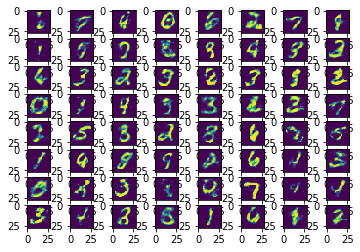

In [9]:
# Generated samples
from IPython.display import display
imgs = np.reshape(samples,(-1,28,28))

for i in range(64):
    plt.subplot(8,8,i+1)
    plt.imshow(imgs[i])